In [1]:
import numpy as np
from get_border_cases import get_border_cases
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib2 import Path

In [2]:
figures_dir = Path('../data/figures/2023.08.31')
figures_dir.mkdir(exist_ok=True, parents=True)

In [40]:
n = 17
n = 101
N = n - 1
inner_n = n - 2
border_cases = get_border_cases(N)
params = np.ones(inner_n ** 2)

In [41]:
'''
    Computes the value of a game.
    game is 2x2 matrix.
'''
def get_value(game):
    return (game[0, 0] * game[1, 1] - game[0, 1] * game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 1.
'''
def get_p1(game):
    return (game[1, 1] - game[1, 0]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Compute optimal strategy for player 2.
'''
def get_q1(game):
    return (game[1, 1] - game[0, 1]) / (game[0, 0] + game[1, 1] - game[1, 0] - game[0, 1])

'''
    Converts global index to inner index.
    index - index to convert.
    inner_n - inner dimension (without borders).
    global_n - outer dimension (with borders).
'''
def inner_n_to_global_N(index, inner_n, global_n):
    row = index // inner_n
    col = index % inner_n
    global_index = (row + 1) * global_n + (col + 1)
    return global_index

def global_N_to_inner_n(index, inner_n, global_n):
    row = index // global_n
    col = index % global_n

    if row < 1 or col < 1 or row > global_n - 2 or col > global_n - 2:
        raise ValueError("Index should match an inner node.")
    inner_index = (row - 1) * inner_n + (col - 1)
    return inner_index

'''
    Checks if a game matrix has saddles.
'''
def check_for_saddle(game):
    maximin = np.max(np.min(game, axis=1))
    minimax = np.min(np.max(game, axis=0))
    res = 'N'
    if np.isclose(maximin, minimax, rtol=1e-8, atol=1e-8):
        res = maximin
        index = next(i for i, _ in enumerate(game.flatten()) if np.isclose(_, res, rtol=1e-8, atol=1e-8)) 
        return res, (1 - index // 2, 1 - index % 2) # fixed
    return 'N'
    
def get_game(index, w):
    game = np.zeros((2, 2))
    game[0, 0] = compute_a11(index, w)
    game[0, 1] = compute_a12(index, w)
    game[1, 0] = compute_a21(index, w)
    game[1, 1] = compute_a22(index, w)
    return game

# Up
def compute_a11(index, w):
    if (index - n) in border_cases:
        a11 = 1
    else:
        a11 = w[global_N_to_inner_n(index - n, inner_n, n)] + 1
    return a11
    
# Down
def compute_a21(index, w):
    if (index + n) in border_cases:
        a12 = 1
    else:
        a12 = w[global_N_to_inner_n(index + n, inner_n, n)] + 1
    return a12

# Right
def compute_a12(index, w):
    if (index + 1) in border_cases:
        a21 = 1
    else:
        a21 = w[global_N_to_inner_n(index + 1, inner_n, n)] + 1
    return a21

# Left
def compute_a22(index, w):
    if (index - 1) in border_cases:
        a22 = 1
    else:
        a22 = w[global_N_to_inner_n(index - 1, inner_n, n)] + 1
    return a22
    

'''
    Number of values in w should match number of equations.
'''
def prepare_equations(w):
    eqs = np.zeros(len(w))
    p1s = []
    q1s = []
    for i in range(len(w)):
        index = inner_n_to_global_N(i, inner_n, n)
        game_mx = get_game(index, w)
        saddle = check_for_saddle(game_mx)
        if saddle == "N":
            v = get_value(game_mx)
            p1 = get_p1(game_mx)
            q1 = get_q1(game_mx)
        else:
            v, (p1, q1) = saddle

        p1s.append(p1)
        q1s.append(q1)
        eqs[i] = w[i] - v

    return tuple(eqs)

### Using fixed point iteration

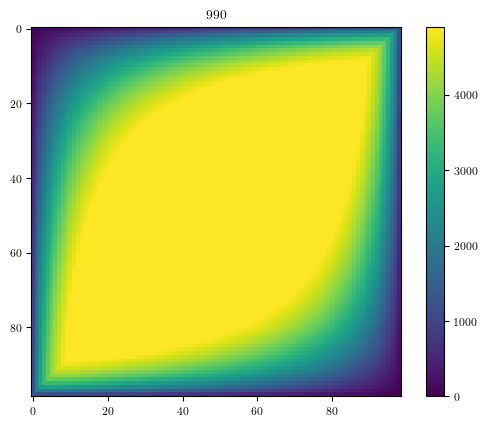

100%|██████████| 1000/1000 [16:52<00:00,  1.01s/it]


In [45]:
def compute_new_values(w, need_p=False):
    w_new = np.zeros(len(w))
    p1s = []
    q1s = []
    for i in range(len(w)):
        index = inner_n_to_global_N(i, inner_n, n)
        game_mx = get_game(index, w)
        saddle = check_for_saddle(game_mx)
        if saddle == "N":
            v = get_value(game_mx)
            p1 = get_p1(game_mx)
            q1 = get_q1(game_mx)
        else:
            v, (p1, q1) = saddle

        p1s.append(p1)
        q1s.append(q1)
        w_new[i] = v
    if need_p:
        return w_new, p1s, q1s
    else:
        return w_new
import matplotlib
%matplotlib inline
from IPython.display import clear_output
import time 
from tqdm import tqdm

w = np.zeros(inner_n ** 2)
#w[8 * inner_n + 8] = 1
Q_exp = inner_n ** 2 / 2
w[:] = Q_exp
fig = plt.figure()
im = plt.imshow(w.reshape(inner_n, inner_n), vmin=0, vmax=Q_exp)
plt.colorbar()
plt.show()
for i in tqdm(range(1000)):
    wn = compute_new_values(w)
    err = np.max(np.abs(w - wn))
    w = wn
    #print(w.sum())
    if i % 10 == 0:
        print(err)
        
        clear_output(wait=True)
        im = plt.imshow(w.reshape(inner_n, inner_n), vmin=0, vmax=Q_exp)
        plt.colorbar()
        plt.title(f'{i}')
        plt.show()
        #time.sleep(0.1)   
w_best = w.copy()

In [52]:
vs, p1s, q1s = compute_new_values(w_best, need_p=True)


In [7]:
np.max(np.abs(w_best - vs))

1.2163385349595046e-05

In [15]:
vs[0], p1s[0], q1s[0]

(9.005494335371038, 0.5, 0.5)

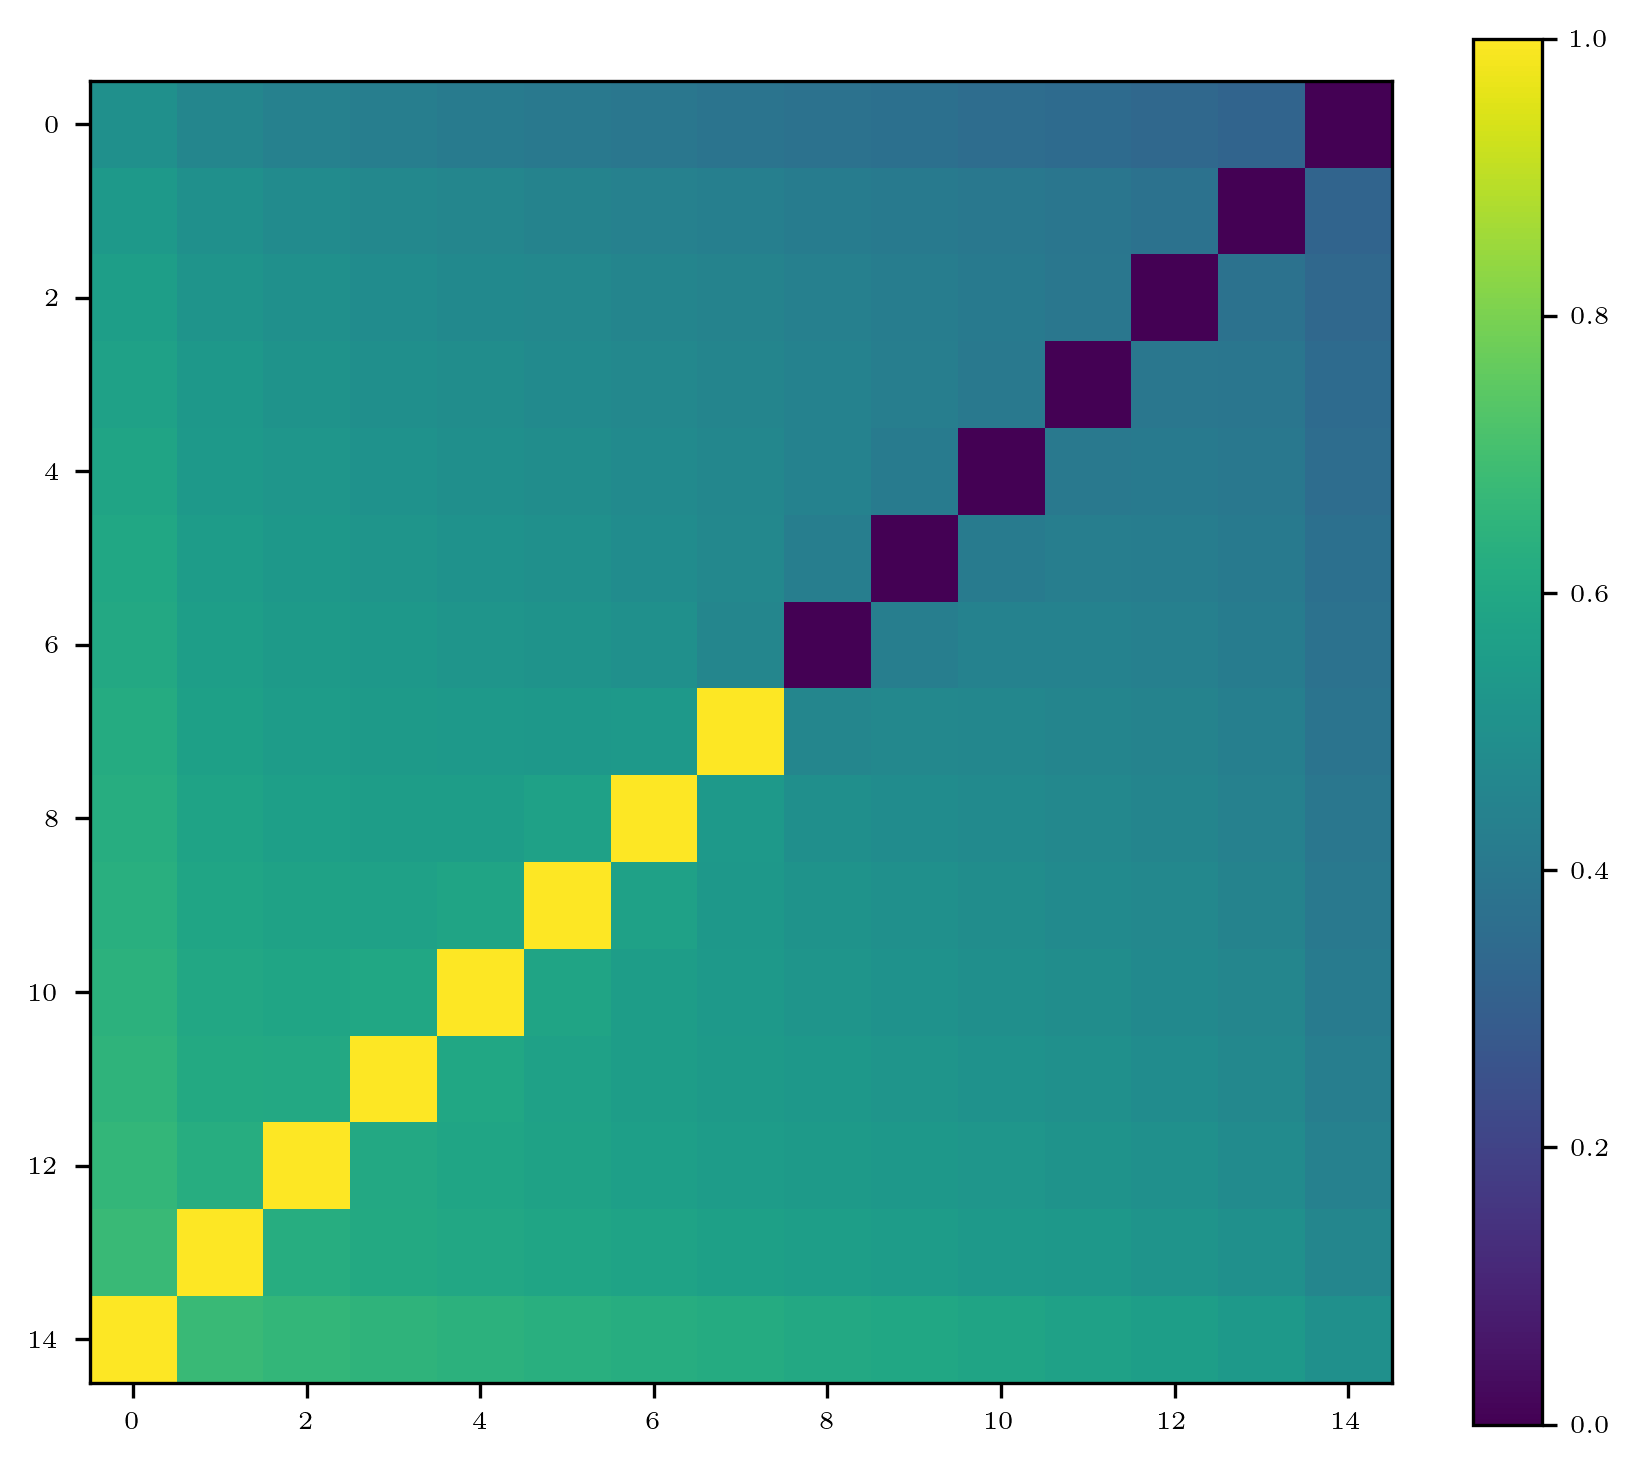

In [21]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(7, 6))
ax.invert_yaxis()
    
plt.imshow(np.reshape(p1s, newshape=(inner_n, inner_n)))

plt.colorbar()
plt.show()

### Using fsolve to find solution

In [42]:
# first launch first line and then uncomment others

from scipy.optimize import fsolve


starting_params = np.random.random(inner_n ** 2) * (inner_n - 1) ** 2 * 0.68
#starting_params = starting_params.reshape(inner_n, inner_n)
#starting_params[1:-1, 1:-1] = np.array(vs).reshape(inner_n - 2, inner_n - 2)
#starting_params = starting_params.flatten()
#starting_params = np.ones(inner_n ** 2) * 3
w_new, _, _, message  = fsolve(prepare_equations, tuple(starting_params), full_output=True)
print(message)

KeyboardInterrupt: 

In [ ]:
(inner_n - 1) ** 2 * 0.68, w_new.reshape(inner_n, inner_n)[inner_n // 2, inner_n // 2]

(133.28, 122.76321908874678)

In [ ]:
p1s = []
q1s = []
vs = []
for i in range(inner_n ** 2):
    index = inner_n_to_global_N(i, inner_n, n)
    game_mx = get_game(index, w_new)
    saddle = check_for_saddle(game_mx)

    #print(f"index = {index}")
    #print(f"game_mx:\n {game_mx}")
    #print(f"saddle = {saddle}")
    if saddle == "N":
        v = get_value(game_mx)
        p1 = get_p1(game_mx)
        q1 = get_q1(game_mx)
        #print(f"p1 form N: {p1}")
    else:
        v, (p1, q1) = saddle

    #print(f"v = {v}")
    #print(f"p1 = {p1}")
    #print(f"q1 = {q1}")
    p1s.append(p1)
    q1s.append(q1)
    vs.append(v)

### Save strategies

In [ ]:
strategy_pvp_center_optimal = np.zeros((N + 1, N + 1))
strategy_pvp_border_optimal = np.zeros((N + 1, N + 1))

strategy_pvp_center_optimal[1:N, 1:N] = 1 - np.array(p1s).reshape(N - 1, N - 1)
strategy_pvp_border_optimal[1:N, 1:N] = 1 - np.array(q1s).reshape(N - 1, N - 1)

np.save("../data/strategy_pvp_center_optimal.npy", strategy_pvp_center_optimal)
np.save("../data/strategy_pvp_border_optimal.npy", strategy_pvp_border_optimal)

### Plot mean number of turns

In [26]:
matplotlib.use("pgf")

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'lualatex',
    'pgf.preamble': r'\usepackage{fontspec} \setmainfont{Times New Roman}',
})
matplotlib.rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex',preamble=r'\usepackage[russian]{babel}')


def plot_mean_abs_time(vs):
    fig = plt.figure(figsize=(7, 6))
    plt.imshow(np.reshape(vs, newshape=(inner_n, inner_n)), vmin=0)
    plt.colorbar()
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    font = {'family' : 'Times New Roman',
            'size'   : 6}
    mpl.rc('font', **font)
    for (j, i), label in np.ndenumerate(np.reshape(vs, newshape=(inner_n, inner_n))):
        plt.text(i, j, f"{label:.1f} ", ha='center', va='center')
        plt.text(i, j, f"{label:.1f} ", ha='center', va='center')
    #plt.title("Mean absorption time")
    return fig

from matplotlib.backends.backend_pdf import PdfPages
path_figure = figures_dir / "pvp_optimal_mean_times"
print(path_figure)
with PdfPages(path_figure.with_suffix('.pdf')) as pdf:
    fig = plot_mean_abs_time(vs)
    fig.savefig(path_figure.with_suffix('.png'), bbox_inches='tight')
    #fig.savefig(path_figure.with_suffix('.svg'))
    pdf.savefig(fig, bbox_inches='tight')



..\data\figures\2023.08.31\pvp_optimal_mean_times


In [24]:
border_color_3 = np.array([204, 153, 255]) / 255.0
border_color_2 = np.array([178, 102, 255]) / 255.0
border_color_1 = np.array([141, 29, 255]) / 255.0
white_color = np.array([255, 255, 255]) / 255.0
center_color_1 = np.array([255, 202, 26]) / 255.0
center_color_2 = np.array([255, 219, 102]) / 255.0
center_color_3 = np.array([255, 231, 153]) / 255.0
rwgame_cmap = mcolors.LinearSegmentedColormap.from_list(
        'rwgame', [border_color_1, border_color_2, border_color_3, white_color, center_color_3, center_color_2, center_color_1])

In [51]:
matplotlib.use("pgf")

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'lualatex',
    'pgf.preamble': r'\usepackage{fontspec} \setmainfont{Times New Roman}',
})
matplotlib.rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex',preamble=r'\usepackage[russian]{babel}')

def plot_strategy(p, player='B'):
    fig, ax = plt.subplots(1, 1, dpi=300, figsize=(7, 6))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    inner_n = 15
    p = np.reshape(p, newshape=(inner_n, inner_n))
    if player == 'A':
        p[inner_n // 2, inner_n // 2] = 0.5
    if player == 'B':
        p[np.arange(inner_n), np.arange(inner_n - 1, -1, -1)] = 0.5

    a = ax.imshow(p, cmap=rwgame_cmap, vmin=0, vmax=1)
    
    
    lr_sym = r'\makebox[0pt][l]{\raisebox{-3pt}{$\leftarrow$}}$\rightarrow$'
    ud_sym = r'$\mathbin\downarrow\hspace{-.4em}\uparrow$'
    
    ld_sym = r'\makebox[0.65em][l]{\raisebox{0.4em}{$\leftarrow$}}$\downarrow$'
    ru_sym = r'\makebox[-0.2em][l]{\raisebox{-0.4em}{$\rightarrow$}}$\uparrow$'

    if player == 'B':
        sym_1 = ud_sym
        sym_2 = lr_sym
        title = r"$\textrm{Вероятность игрока <<за границу>> выбрать 1 стратегию}$"
    elif player == 'A':
        sym_1 = ru_sym
        sym_2 = ld_sym
        title = r"$\textrm{Вероятность игрока <<за центр>> выбрать 1 стратегию}$"
    
    font = {'family' : 'Times New Roman',
            'size'   : 6}

    matplotlib.rc('font', **font)
    for (j, i), label in np.ndenumerate(p):
        print_str_1 = f"\n{sym_1}" if np.isclose(label, 1) else ""
        print_str_2 = f"\n{sym_2}" if np.isclose(label, 0) else ""
        plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')
        plt.text(i, j, f"{label:.2f} " + print_str_1 + print_str_2, ha='center', va='center')

    font = {'family' : 'Times New Roman',
            'size'   : 8}
    mpl.rc('font', **font)

    cbar = fig.colorbar(a)
    cbar.ax.text(3, 1, sym_1, ha='center', va='center')
    #cbar.ax.text(2, 0.03, '0', ha='center', va='center')
    cbar.ax.text(3, 0.0, sym_2, ha='center', va='center')

    ax.set_title(title)
    return fig
    
from matplotlib.backends.backend_pdf import PdfPages
path_figure = figures_dir / "pvp_center_strategy"
print(path_figure)
with PdfPages(path_figure.with_suffix('.pdf')) as pdf:
    fig = plot_strategy(p1s, player='A')
    #fig.savefig(path_figure.with_suffix('.png'), bbox_inches='tight')
    #fig.savefig(path_figure.with_suffix('.svg'))
    pdf.savefig(fig, bbox_inches='tight')

path_figure = figures_dir / "pvp_border_strategy"
print(path_figure)
with PdfPages(path_figure.with_suffix('.pdf')) as pdf:
    fig = plot_strategy(q1s, player='B')
    #fig.savefig(path_figure.with_suffix('.png'), bbox_inches='tight')
    #fig.savefig(path_figure.with_suffix('.svg'))
    pdf.savefig(fig, bbox_inches='tight')


..\data\figures\2023.08.31\pvp_center_strategy
..\data\figures\2023.08.31\pvp_border_strategy


In [49]:
len(p1s)

225

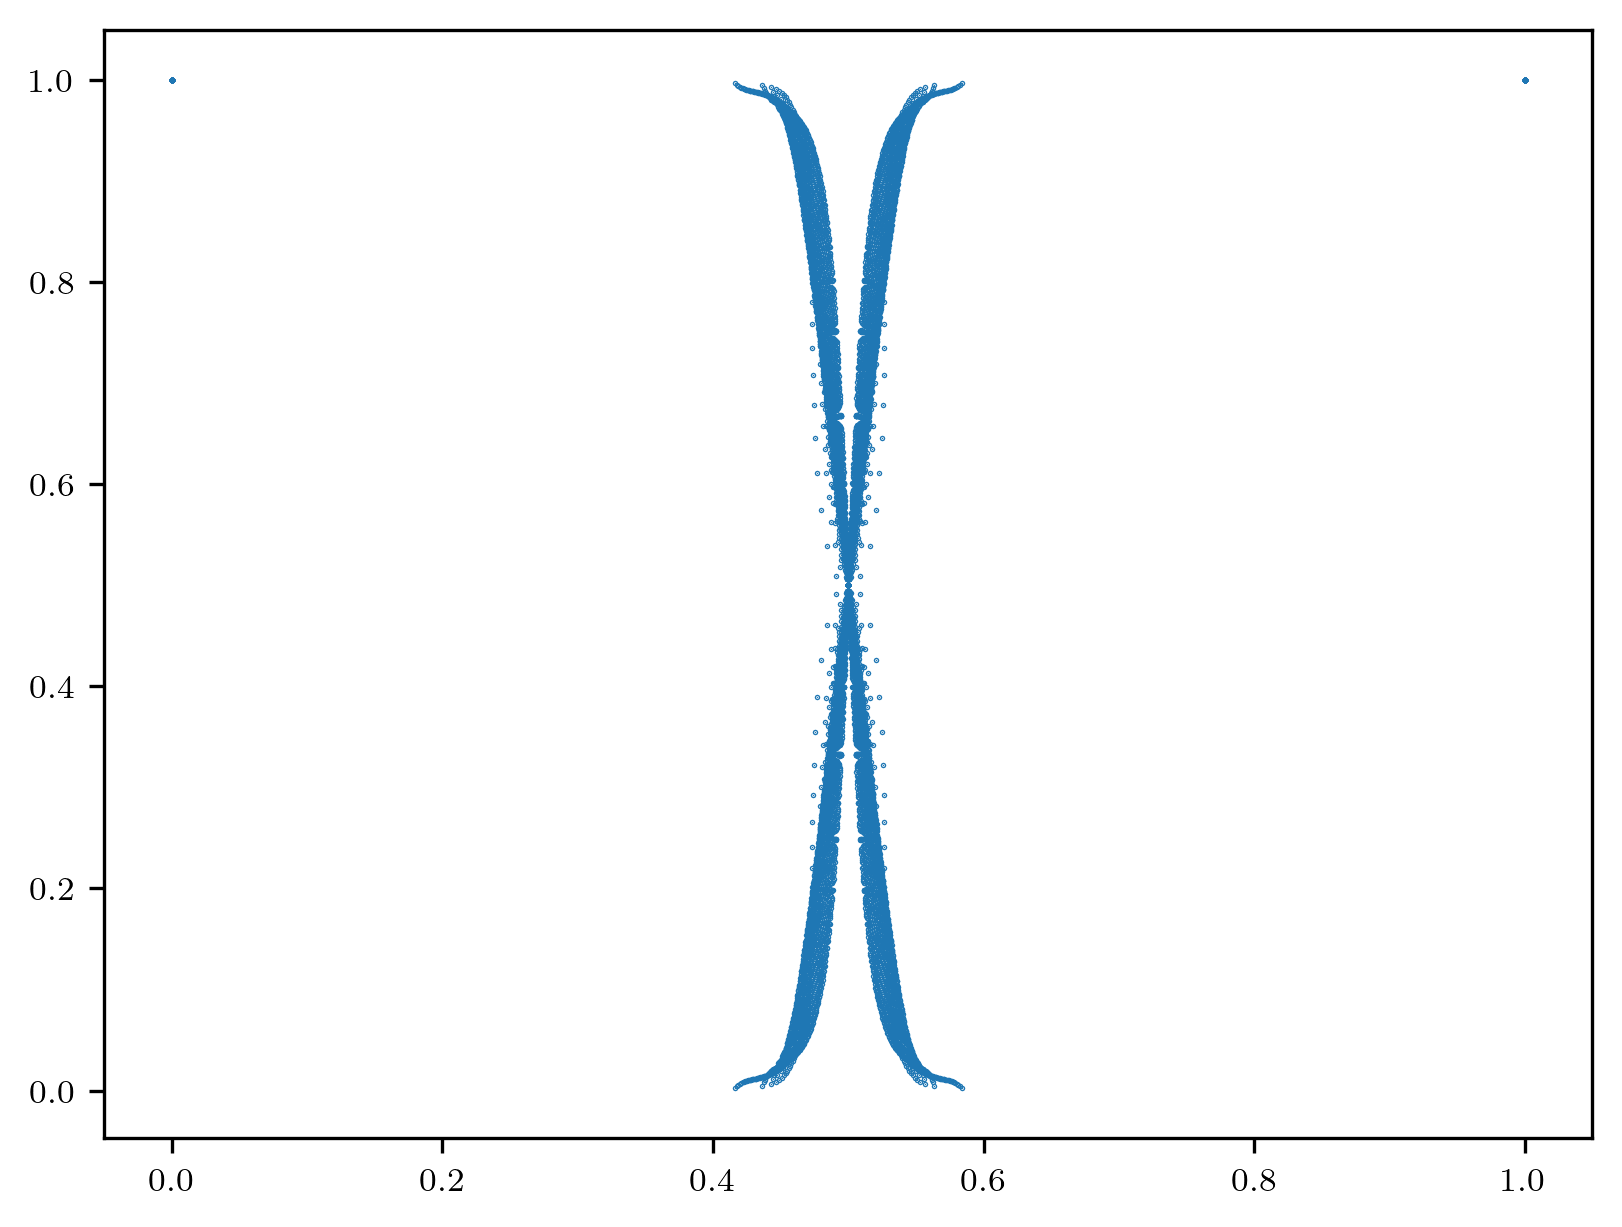

In [55]:
matplotlib.use("nbAgg")
%matplotlib inline

plt.figure(dpi=300)
plt.scatter(p1s, q1s, s=0.1)
plt.savefig(figures_dir / 'strategy_probs_dependence_100.png')
plt.show()

In [29]:
p1sn = np.array(p1s)
np.mean(p1sn[(p1sn > 0.5) & (p1sn < 1)])

0.5666998676067654

In [31]:
q1sn = np.array(q1s)
np.mean(q1sn[(q1sn > 0.5) & (q1sn < 1)])

0.7413625369401209

In [39]:
q1sn_border = q1sn[:15]
print(q1sn_border)
np.mean(1 - q1sn_border[(q1sn_border < 0.5)])

[0.5        0.31926918 0.23324691 0.18305131 0.15015786 0.12689045
 0.10948406 0.09585367 0.0847139  0.07516299 0.0664251  0.05758546
 0.04709742 0.03142112 1.        ]


0.8784338889749352